<a href="https://colab.research.google.com/github/Stepeech/DataMining/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%965_%D0%A1%D0%BE%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BF%D1%80%D0%BE%D1%81%D1%82%D0%BE%D0%B9_%D1%80%D0%B5%D0%BA%D0%BE%D0%BC%D0%B5%D0%BD%D0%B4%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D0%B9_%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D1%8B_%D0%BD%D0%B0_%D0%BE%D1%81%D0%BD%D0%BE%D0%B2%D0%B5_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D0%BE%D0%B2_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практическая работа №5. Создание простой рекомендательной системы на основе алгоритмов кластеризации

На основе оценок аниме, которые ставят пользователи систем типа [MAL](https://myanimelist.net/), можно строить разные кластеры данных:
- кластеры похожих людей. Похожие значит, что эти люди ставят похожие рейтинги аниме.
- кластеры похожих аниме. Похожие значит что люди оценивают их похоже.
- кластеры похожих жанров. Но похожие не в обычном смысле, а в смысле, что люди которые смотрят жанр А любят смотреть жанр Б.

и т.д.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)
- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную



In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm # Раскоментируйте если прогресс бар будет странно работать

%matplotlib inline

# Зафиксируем случайность, чтобы у нас получались одинаковые результаты.
np.random.seed(seed=42)

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [2]:
colab = True  # True если используте google colab
if colab:
    from google.colab import drive
    drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
if colab:
    anime = pd.read_csv('/content/drive/My Drive/Colab Notebooks/anime.csv', index_col='anime_id')
else:
    anime = pd.read_csv('../data/anime/anime.csv', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...
9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
5543,Under World,Hentai,OVA,1,4.28,183
5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219


In [4]:
if colab:
    ratings = pd.read_csv('/content/drive/My Drive/Colab Notebooks/rating.csv')
else:
    ratings = pd.read_csv('../data/anime/rating.csv')
ratings

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


Датасет очень большой и грязный. Некоторые действия с этим датасетом будут требовать много оперативной памяти(>6 Гб).

## Подготовка данных

Во первых, в датасете есть много -1. Оценки -1 и 0 на MAL нет.

Здесь -1 означает что человек посмотрел это аниме, но не выставил оценку.

Такие записи из `ratings` стоит выбросить, так как в нашем случае они особо не помогут.

Но и не помешают серьезно. Если хотите оставьте их, только нужно заменить все -1 на 0, так как дальше нам понадобится посчитать среднее, а -1 или 0, в отличие от `np.nan`, повлияют на среднее.

### 1. Избавьтесь от -1

In [5]:
ratings = ratings.drop(np.where(ratings['rating'] == -1)[0])
ratings

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


## Критерий Шавене (Chauvenet)

$$ erfc(\frac{|P_i - mean(P)|}{S_p})  < \frac{1}{2n}$$

$ S_p - отклонение $

Готовой реализации в библиотеках нет, поэтому придется написать самим(но если найдете можете использовать).

### 2. Напишите функцию, которая принимает на вход массив, считает критерий Шавене и возвращает булеву маску.

Функция `erfc` есть в sklearn.

In [7]:
from scipy.special import erfc

def chauvenet(data, mean_factor=3):
    mean = sum(data) / len(data)
    variance = sum((x - mean) ** 2 for x in data) / len(data)
    std_dev = variance ** 0.5

    lower_bound = mean - mean_factor * std_dev
    upper_bound = mean + mean_factor * std_dev

    mask = [True if x < lower_bound or x > upper_bound else False for x in data]
    return mask

Для начала давайте посмотрим на таблицу рейтингов.

### 3. Сделайте новую таблицу `count_reviews` где индексами будет `user_id` а значением будет количество просмотренных им аниме.


**Hint** Используйте [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) и [count](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.count.html).

In [6]:
count_reviews = ratings.groupby('user_id').agg({'anime_id': 'count'})
count_reviews.rename(columns={'anime_id': 'count_reviews'}, inplace=True)

count_reviews

,count_reviews
user_id,
1,4
2,1
3,92
5,459
7,343
...,...
73512,12
73513,33
73514,1


### 4. Используйте функцию chauvenet и найдите все выбросы.

**Hint:** Так как chauvenet возвращает маску используйте оператор `[]` (подробнее смотрите в теории по pandas и numpy).

**Hint:** Используйте [values](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.values.html).

In [8]:
outliers_mask = chauvenet(count_reviews['count_reviews'])
outlier_users = count_reviews[outliers_mask]

outlier_users

,count_reviews
user_id,
226,742
271,599
294,675
392,598
446,743
...,...
73362,596
73378,723
73395,585


### 5. Ответьте на вопросы

#### Кого критерий посчитал выбросом?

#### Почему критерий посчитал их выбросом?

#### Нужна ли им вообще рекомендательная система?


**Ответы:**

Критерий посчитал выбросом пользователей с количеством отзывов меньше, чем 500. А выбросом он их посчитал, потому что значение в 500 было определено критерием Шавене как критическое для нашего датасета.

In [9]:
bad_user_threshold = outlier_users.min()
bad_user_threshold

count_reviews    499
dtype: int64

Если все было правильно `bad_user_threshold` больше 500.

Нужно выбросить всех людей у которых число просмотренных аниме больше или равно `bad_user_threshold`.

### 6. Переименнуйте столбец из таблицы `count_reviews` в `count_reviews` (он там единственный). Соедините `count_reviews` и `ratings` по столбцу `user_id`. И оставьте в `ratings` только тех кто посмотрел меньше `bad_user_threshold`  

In [10]:
merged_data = pd.merge(count_reviews, ratings, on='user_id')
filtered_ratings = merged_data[merged_data['count_reviews'] < 499]

filtered_ratings

,user_id,count_reviews,anime_id,rating
0,1,4,8074,10
1,1,4,11617,10
2,1,4,11757,10
3,1,4,15451,10
4,2,1,11771,10
...,...,...,...,...
6337236,73515,179,16512,7
6337237,73515,179,17187,9
6337238,73515,179,22145,10
6337239,73516,2,790,9


Осталось все равно слишком много пользователей.

### 7. Удалите из таблицы всех юзеров, у которых количество просмотров меньше медианного значения. То есть мы удалим половину юзеров.

Так как они посмотрели слишком мало, чтобы мы на них могли основывать свои советы.

In [11]:
median_count_reviews = filtered_ratings['count_reviews'].median()

ratings = filtered_ratings[filtered_ratings['count_reviews'] >= median_count_reviews]

ratings

,user_id,count_reviews,anime_id,rating
97,5,459,6,8
98,5,459,15,6
99,5,459,17,6
100,5,459,18,6
101,5,459,20,6
...,...,...,...,...
6337234,73515,179,13659,8
6337235,73515,179,14345,7
6337236,73515,179,16512,7
6337237,73515,179,17187,9


In [12]:
# Удалим столбец с просмотрами чтобы не мешал.

ratings = ratings.drop(columns=['count_reviews'])
ratings

,user_id,anime_id,rating
97,5,6,8
98,5,15,6
99,5,17,6
100,5,18,6
101,5,20,6
...,...,...,...
6337234,73515,13659,8
6337235,73515,14345,7
6337236,73515,16512,7
6337237,73515,17187,9


Теперь рассмотрим таблицу `anime`.


Так же применим критерий шавене.

Искать выбросы стоит по столбцу `rating` или по `members` или по обоим сразу.

### 8. Используйте функцию chauvenet и найдите все выбросы среди аниме. И удалите их.

**Hint** Используйте [drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) и [index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.index.html)

In [13]:
outliers_mask = chauvenet(anime['rating'])
outliers_indices = anime[outliers_mask].index
outlier_anime = anime[outliers_mask]
anime.drop(index=outliers_indices, inplace=True)
anime

,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...
9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
5543,Under World,Hentai,OVA,1,4.28,183
5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219


### 9. Ответье на вопросы

#### Что критерий посчитал выбросом?

#### Почему критерий посчитал их выбросом?

#### Можем ли мы как то использовать эти аниме в нашей рекомендательное системе?

**Ответы:**


Критерий посчитал выбросм аниме с рейтингом меньше 3.5 и больше 9.6. Если разница между измерением и средним значением больше определенного критического значения (в нашем случае в 3 стандартных отклонения), это измерение считается выбросом. Эти выбросы мы можем использовать в рекомендательных системах в целом, но в некоторых моделях, которые могут обрабатывать выбросы более эффективно и предоставлять более точные рекомендации при их присутствии (выбросов)

## Кластеризация по жанрам

Данные о жанре хранятся как строка, разделенная запятой `,` . Но нам нужны сами жанры. Придется поколдовать и разделить эту строку на элементы.

In [14]:
from itertools import chain
'''
Нам нужна функция flatmap.
Flatmap получает на вход список, на каждом элементе вызывает функцию f, которая возвращает другой список.
В результате получается список списков. (flatten - уплощение списка списков в один список).
'''
def flatmap(f, items):
    return chain.from_iterable(map(f, items))

# пример использования
list(flatmap(lambda x: [0, x , x*x], [1,2,3,4,5]))
# Первый шаг: [[0, 1, 1], [0, 2, 4], [0, 3, 9], [0, 4, 16], [0, 5, 25]]

[0, 1, 1, 0, 2, 4, 0, 3, 9, 0, 4, 16, 0, 5, 25]

In [15]:
# создаем функцию, которая просто разбивает строку по символу ", " на подстроки
def genre_splitter(genre_names):
    return genre_names.split(", ")

m_uniq = anime['genre'].unique() # смотрим сколько всего уникальных комбинация genres есть в датасете
print("m_uniq[0:10] = {}\nlen= {}\n".format(m_uniq[0:10], len(m_uniq))) # как видим комбинаций очень много, так как там все композиции

genres = set(flatmap(genre_splitter, m_uniq)) # разбиваем все genres на составные части и генерируем один массив из всех жанров. Строим по массиву множество уникальных жанров

genres = list(genres) # множество превращаем в список
print("Genres={}\nlen={}".format(genres, len(genres)))

m_uniq[0:10] = ['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen'
 'Sci-Fi, Thriller' 'Comedy, Drama, School, Shounen, Sports'
 'Action, Adventure, Shounen, Super Power'
 'Drama, Military, Sci-Fi, Space'
 'Drama, Fantasy, Romance, Slice of Life, Supernatural'
 'Drama, School, Shounen'
 'Action, Drama, Mecha, Military, Sci-Fi, Super Power']
len= 3224

Genres=['Music', 'Ecchi', 'Seinen', 'Shoujo', 'Thriller', 'Shoujo Ai', 'Josei', 'Magic', 'Parody', 'Historical', 'Military', 'Space', 'Game', 'Yuri', 'Romance', 'Fantasy', 'Harem', 'Shounen Ai', 'Mecha', 'Action', 'Cars', 'Hentai', 'Drama', 'Super Power', 'Martial Arts', 'Samurai', 'Sports', 'Mystery', 'Psychological', 'Horror', 'Dementia', 'Kids', 'Slice of Life', 'School', 'Police', 'Yaoi', 'Vampire', 'Comedy', 'Adventure', 'Supernatural', 'Shounen', 'Demons', 'Sci-Fi']
len=43


### 10. Создадим новую таблицу, где в колонках будет жанр, в строках аниме, а в ячейках 1 если у фильма есть этот жанр и 0 в противном случае.

Такой формат таблиц называтеся one-hot-encoding. Только в нашем случае в каждой строке будет не одна единица, а несколько, так как у аниме как правило несолько жанров.

Уточнение: жанры должны быть индексами столбцов (columns), а id аниме - индексами строк (index)

In [16]:
[column for column in anime]

['name', 'genre', 'type', 'episodes', 'rating', 'members']

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
anime_genres = list(map(lambda x: list(map(lambda x: x.strip(), x.split(','))), anime['genre']))
anime_genres_b = mlb.fit_transform(anime_genres)

anime_genres_df = pd.DataFrame(
    columns=mlb.classes_,
    data=anime_genres_b
)

anime_genres_df['anime_id'] = anime.index
anime_genres_df = anime_genres_df.set_index('anime_id')
anime_genres_df

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
anime_id,,,,,,,,,,,,,,,,,,,,,
32281,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5114,1,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
28977,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9969,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Итак, у нас есть следующие таблицы:
- Жанры аниме - в строчках аниме, в столбцах жанр аниме, а в ячейках 0 или 1.
- Рейтинги - в строчках пользователи, в столбцах id аниме и рейтинг

Нужно получить другую таблицу, в которой в строках будут пользователи, а в столбцах жанры аниме. А в ячейках средняя оценка жанра этим пользователем.

Средняя оценка жанра вычисляется следующим образом: берём все отзывы пользователя. Группируем все его отзывы по жанрам и считаем средний рейтинг, который он ставит аниме с данным жанром.

Выполним следущие шаги.

### 11. Соединим две таблицы:<br>
1. жанры по каждому аниме<br>
2. оценки аниме от людей. Кстати, один человек мог посмотреть 1 аниме или 100, но не все!<br>

Получим таблицу, где строк будет N*M штук, где N - количество юзеров и M - количество аниме

In [18]:
merged_df = pd.merge(anime_genres_df, ratings, on='anime_id', how='inner')
merged_df

,anime_id,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,...,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,user_id,rating
0,32281,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,244,10
1,32281,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,462,8
2,32281,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,548,10
3,32281,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,598,10
4,32281,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,784,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2674330,5589,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,53303,8
2674331,5589,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,53379,5
2674332,5589,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,67312,1
2674333,4310,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,49312,2


С такой таблицей `(N*M) * G` вы всё еще не можем работать.  
### 12. Сгруппируем строки по пользователям (колонка `userId`).  В группах посчитаем среднюю оценку на жанр. А если пользователь не смотрел фильм, то поставим ему `-1` в соответсвующую ячейку.
Чтобы посчитать среднее(mean) без учета непросмотренных аниме замените все `0` на `np.NaN`

In [19]:
genre_columns = merged_df.columns[2:44].values

for genre in genre_columns:
    merged_df[genre] = np.where(merged_df[genre] == 1, merged_df['rating'], merged_df[genre])

merged_df.replace(0, np.nan, inplace=True)

user_genre_ratings = merged_df.groupby('user_id')[genre_columns].mean()

user_genre_ratings

,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
user_id,,,,,,,,,,,,,,,,,,,,,
5,5.186813,6.0,4.155763,1.000000,4.157895,5.217949,2.510000,4.410526,4.100000,2.217949,...,NaN,4.506849,7.250000,6.000000,4.170732,4.346939,7.285714,4.428571,NaN,NaN
7,7.700000,NaN,7.297980,9.333333,7.250000,7.750000,6.909091,7.337209,7.666667,7.111111,...,NaN,7.137255,NaN,7.333333,7.939394,7.631579,8.363636,7.444444,NaN,NaN
17,7.458333,8.0,6.730570,8.600000,6.750000,7.264706,6.696970,6.973684,7.153846,6.433333,...,NaN,6.900000,7.444444,7.444444,6.900000,7.376238,8.062500,7.200000,NaN,NaN
21,7.655172,6.5,7.552632,9.400000,7.375000,7.931818,6.500000,7.348837,5.000000,7.222222,...,6.000000,7.714286,8.333333,7.200000,7.769231,7.740741,9.000000,8.333333,NaN,NaN
38,7.775000,NaN,5.966292,10.000000,5.937500,7.019231,4.324324,6.883333,8.777778,4.212121,...,3.000000,6.437500,6.750000,8.250000,7.175000,6.969072,8.052632,6.214286,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73485,7.093023,9.0,7.269231,7.250000,6.250000,7.333333,6.000000,7.170732,NaN,5.500000,...,NaN,7.357143,7.000000,8.500000,7.000000,7.204082,7.750000,6.500000,NaN,NaN
73500,8.272727,NaN,7.959184,1.000000,7.428571,8.000000,7.625000,8.305556,10.000000,7.615385,...,7.882353,8.000000,9.000000,7.000000,8.500000,8.142857,9.500000,7.666667,7.75,NaN
73503,6.157895,NaN,6.019231,8.000000,5.954545,6.944444,5.230769,6.022472,5.857143,4.700000,...,NaN,7.277778,6.625000,5.500000,6.428571,6.489796,7.476190,6.125000,NaN,NaN


Так как некоторые пользователи не смотрели ничего из некоторых жанров, в данных осталось много `np.NaN`
### 13. Заполните все NaN на -1

**Hint** [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)

In [20]:
user_genre_ratings = user_genre_ratings.fillna(-1)
user_genre_ratings

,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
user_id,,,,,,,,,,,,,,,,,,,,,
5,5.186813,6.0,4.155763,1.000000,4.157895,5.217949,2.510000,4.410526,4.100000,2.217949,...,-1.000000,4.506849,7.250000,6.000000,4.170732,4.346939,7.285714,4.428571,-1.00,-1.0
7,7.700000,-1.0,7.297980,9.333333,7.250000,7.750000,6.909091,7.337209,7.666667,7.111111,...,-1.000000,7.137255,-1.000000,7.333333,7.939394,7.631579,8.363636,7.444444,-1.00,-1.0
17,7.458333,8.0,6.730570,8.600000,6.750000,7.264706,6.696970,6.973684,7.153846,6.433333,...,-1.000000,6.900000,7.444444,7.444444,6.900000,7.376238,8.062500,7.200000,-1.00,-1.0
21,7.655172,6.5,7.552632,9.400000,7.375000,7.931818,6.500000,7.348837,5.000000,7.222222,...,6.000000,7.714286,8.333333,7.200000,7.769231,7.740741,9.000000,8.333333,-1.00,-1.0
38,7.775000,-1.0,5.966292,10.000000,5.937500,7.019231,4.324324,6.883333,8.777778,4.212121,...,3.000000,6.437500,6.750000,8.250000,7.175000,6.969072,8.052632,6.214286,-1.00,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73485,7.093023,9.0,7.269231,7.250000,6.250000,7.333333,6.000000,7.170732,-1.000000,5.500000,...,-1.000000,7.357143,7.000000,8.500000,7.000000,7.204082,7.750000,6.500000,-1.00,-1.0
73500,8.272727,-1.0,7.959184,1.000000,7.428571,8.000000,7.625000,8.305556,10.000000,7.615385,...,7.882353,8.000000,9.000000,7.000000,8.500000,8.142857,9.500000,7.666667,7.75,-1.0
73503,6.157895,-1.0,6.019231,8.000000,5.954545,6.944444,5.230769,6.022472,5.857143,4.700000,...,-1.000000,7.277778,6.625000,5.500000,6.428571,6.489796,7.476190,6.125000,-1.00,-1.0


Прежде чем начать обучать kMeans...

### 14. Отмасштабируйте признаки.

Как мы знаем по лекции, метрическим алгоритмам, одним из которых и является kMeans, лучше подавать на вход данные одного масштаба.  Этим и занимается метод MinMaxScaler из sklearn.

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

Алгоритм его работы:
```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(user_genre_ratings)
scaled_df = pd.DataFrame(scaled, columns=genre_columns, index=user_genre_ratings.index)

scaled_df

,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
user_id,,,,,,,,,,,,,,,,,,,,,
5,-3.224350,1.120588,-4.390612,-0.908376,-2.751735,-3.694867,-3.832017,-4.071192,-1.587008,-3.442469,...,-0.570914,-3.746042,0.205239,-0.449598,-4.019212,-4.568351,-0.731146,-2.191791,-0.367222,-0.398996
7,-0.180016,-0.604065,-0.472510,1.034629,-0.251827,-0.269456,-0.167202,-0.474510,0.126844,0.021493,...,-0.570914,-0.803210,-2.295547,0.072259,0.208595,-0.289542,0.100328,-0.046342,-0.367222,-0.398996
17,-0.472758,1.613346,-1.180026,0.863645,-0.656067,-0.925972,-0.343917,-0.921256,-0.119576,-0.458319,...,-0.570914,-1.068645,0.264180,0.115747,-0.957431,-0.622168,-0.131959,-0.220236,-0.367222,-0.398996
21,-0.234318,1.243777,-0.154979,1.050173,-0.150767,-0.023489,-0.508009,-0.460220,-1.154541,0.100150,...,1.384380,-0.157643,0.533625,0.020073,0.017700,-0.147340,0.591198,0.586001,-0.367222,-0.398996
38,-0.089165,-0.604065,-2.133022,1.190070,-1.312958,-1.258055,-2.320531,-1.032291,0.660754,-2.030757,...,0.546397,-1.586078,0.053677,0.431036,-0.648927,-1.152571,-0.139571,-0.921459,-0.367222,-0.398996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73485,-0.915274,1.859725,-0.508358,0.548878,-1.060308,-0.833131,-0.924552,-0.679099,-4.037656,-1.119043,...,-0.570914,-0.557205,0.129458,0.528884,-0.845248,-0.846431,-0.373011,-0.718206,-0.367222,-0.398996
73500,0.513753,-0.604065,0.351961,-0.908376,-0.107455,0.068749,0.429211,0.715518,1.248056,0.378477,...,1.910174,0.162007,0.735709,-0.058205,0.837501,0.376486,0.976882,0.111744,3.114547,-0.398996
73503,-2.048036,-0.604065,-2.067012,0.723748,-1.299177,-1.359228,-1.565386,-2.090227,-0.742667,-1.685378,...,-0.570914,-0.645997,0.015786,-0.645294,-1.486295,-1.776911,-0.584219,-0.984976,-0.367222,-0.398996


### 15.Натренируйте kMeans с 10 кластерами на полученных данных

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [35]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(scaled_df)
scaled_df['cluster'] = clusters
scaled_df

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,...,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
5,-3.224350,1.120588,-4.390612,-0.908376,-2.751735,-3.694867,-3.832017,-4.071192,-1.587008,-3.442469,...,-3.746042,0.205239,-0.449598,-4.019212,-4.568351,-0.731146,-2.191791,-0.367222,-0.398996,9
7,-0.180016,-0.604065,-0.472510,1.034629,-0.251827,-0.269456,-0.167202,-0.474510,0.126844,0.021493,...,-0.803210,-2.295547,0.072259,0.208595,-0.289542,0.100328,-0.046342,-0.367222,-0.398996,6
17,-0.472758,1.613346,-1.180026,0.863645,-0.656067,-0.925972,-0.343917,-0.921256,-0.119576,-0.458319,...,-1.068645,0.264180,0.115747,-0.957431,-0.622168,-0.131959,-0.220236,-0.367222,-0.398996,6
21,-0.234318,1.243777,-0.154979,1.050173,-0.150767,-0.023489,-0.508009,-0.460220,-1.154541,0.100150,...,-0.157643,0.533625,0.020073,0.017700,-0.147340,0.591198,0.586001,-0.367222,-0.398996,7
38,-0.089165,-0.604065,-2.133022,1.190070,-1.312958,-1.258055,-2.320531,-1.032291,0.660754,-2.030757,...,-1.586078,0.053677,0.431036,-0.648927,-1.152571,-0.139571,-0.921459,-0.367222,-0.398996,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73485,-0.915274,1.859725,-0.508358,0.548878,-1.060308,-0.833131,-0.924552,-0.679099,-4.037656,-1.119043,...,-0.557205,0.129458,0.528884,-0.845248,-0.846431,-0.373011,-0.718206,-0.367222,-0.398996,4
73500,0.513753,-0.604065,0.351961,-0.908376,-0.107455,0.068749,0.429211,0.715518,1.248056,0.378477,...,0.162007,0.735709,-0.058205,0.837501,0.376486,0.976882,0.111744,3.114547,-0.398996,0
73503,-2.048036,-0.604065,-2.067012,0.723748,-1.299177,-1.359228,-1.565386,-2.090227,-0.742667,-1.685378,...,-0.645997,0.015786,-0.645294,-1.486295,-1.776911,-0.584219,-0.984976,-0.367222,-0.398996,4


### 16. Нарисуйте на графике центры кластеров нашего датасета оценок фильмов.

В нем будет 10 строчек - 10 кластеров. И 43 столбцов - 43 жанров фильмов.

Из графика мы поймем какие жанры обычно смотрят вместе. По сути мы получили кластеры предпочтений людей.

**Hint** [Heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

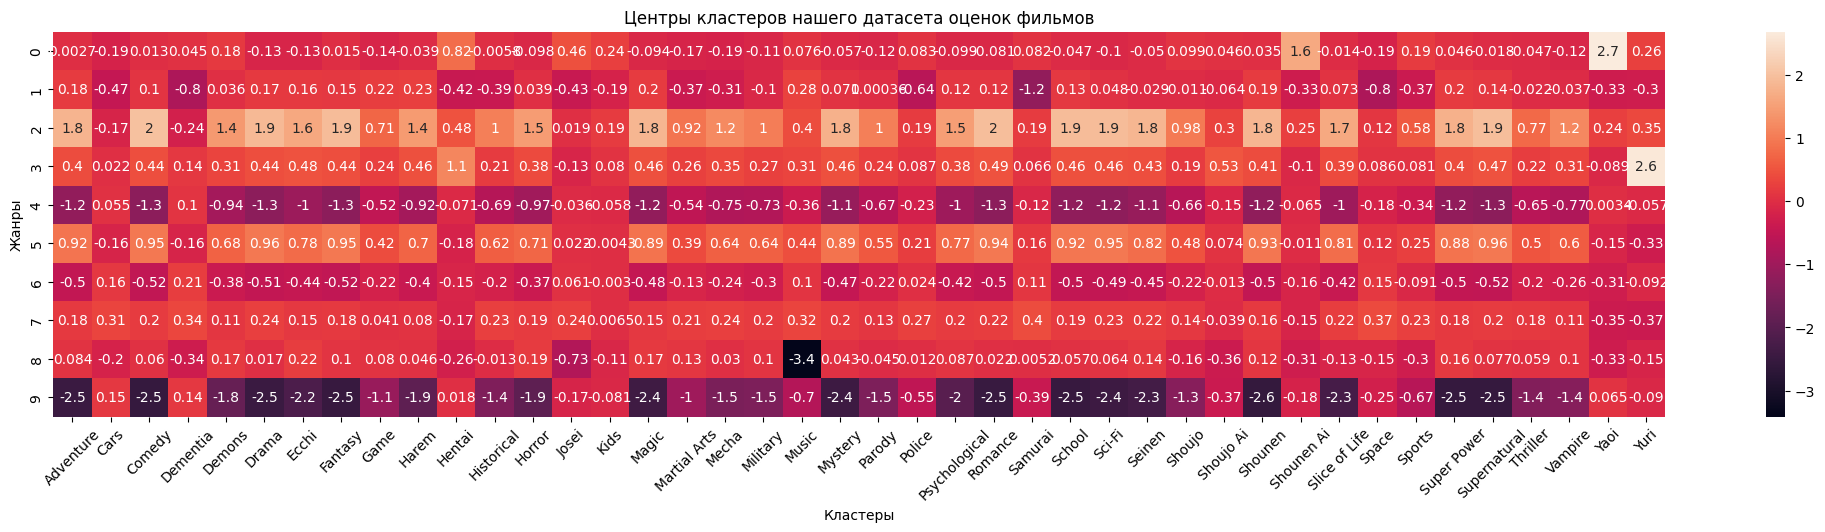

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

cluster_centers = kmeans.cluster_centers_

cluster_centers_df = pd.DataFrame(cluster_centers, columns=scaled_df.columns[:-1])

plt.figure(figsize=(25, 5))
plt.title('Центры кластеров нашего датасета оценок фильмов')
sns.heatmap(cluster_centers_df, annot=True)
plt.xlabel('Кластеры')
plt.ylabel('Жанры')
plt.xticks(rotation=45)
plt.show()

# Как выбрать нужное число кластеров

Такие методы как KMeans, Spectral clustering, Ward hierarchical clustering, Agglomerative clustering требуют количество кластеров как параметр. Это так называемый гипер-параметр, и его должен подбирать человек. Но на что человеку опираться при выборе? На некоторый функционал "качества"!

Вспомним идею кластеризации:
- минимизация внутрикластерного расстояния
- максимизация межкластерного расстояния

Другими словами - кучки кучнее и дальше друг от друга.

Логично, что мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но вот незадача: минимум такого функционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента). Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". Или более формально: $$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Где, в случае kMeans $$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$ - сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся

#### Эта ячейка может выполнятся долго!

  0%|          | 0/29 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  3%|▎         | 1/29 [00:00<00:11,  2.42it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  7%|▋         | 2/29 [00:01<00:22,  1.20it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 10%|█         | 3/29 [00:02<00:25,  1.03it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will cha

Text(0, 0.5, '$J(C_k)$')

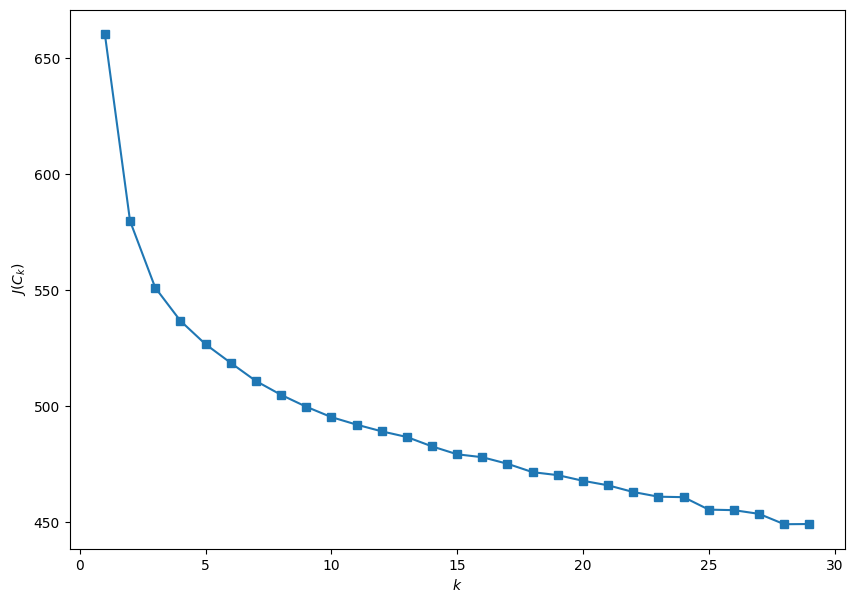

In [46]:
inertia = []
N = 30
for k in tqdm(range(1, N)):
    kmeans = KMeans(n_clusters=k).fit(scaler.fit_transform(scaled_df))
    inertia.append(np.sqrt(kmeans.inertia_))
plt.figure(figsize=(10,7))
plt.plot(range(1, N), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

## Коэффициент силуэта

Данный коэффициент не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации.

Сначала силуэт определяется отдельно для каждого объекта. Обозначим через $a$ - среднее расстояние от данного объекта до объектов из того же кластера, через $b$ - среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина: $$s = \frac{b - a}{\max(a, b)}.$$ Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне $[-1, 1]$. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

С помощью силуэта можно выбирать оптимальное число кластеров $k$ (если оно заранее неизвестно) - выбирается число кластеров, максимизирующее значение силуэта. В отличие от предыдущих метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.

#### Эта ячейка может выполняться долго!

In [47]:
from sklearn.metrics import silhouette_score, silhouette_samples

def draw_sil_score(X, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 20]):
    scores = []
    for n_clusters in tqdm(range_n_clusters):
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append(silhouette_avg)
    plt.plot(range_n_clusters, scores)
    return range_n_clusters[np.argmax(scores)]

  0%|          | 0/28 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  4%|▎         | 1/28 [00:03<01:28,  3.28s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  7%|▋         | 2/28 [00:06<01:20,  3.11s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 11%|█         | 3/28 [00:09<01:21,  3.25s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will cha

2

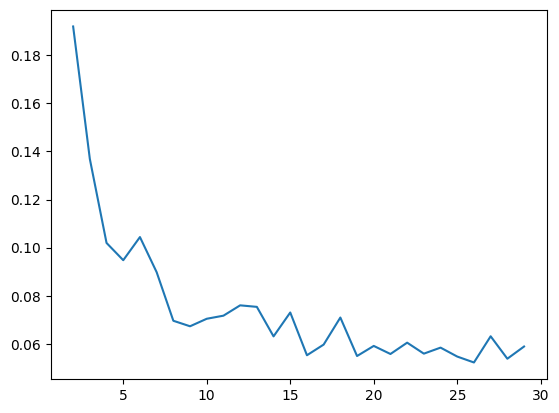

In [48]:
draw_sil_score(scaler.fit_transform(scaled_df), range(2, 30))

### 17. Выберите количество кластеров `k` по методам выше. Натренируйте kMeans и снова нарисуйте heatmap.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


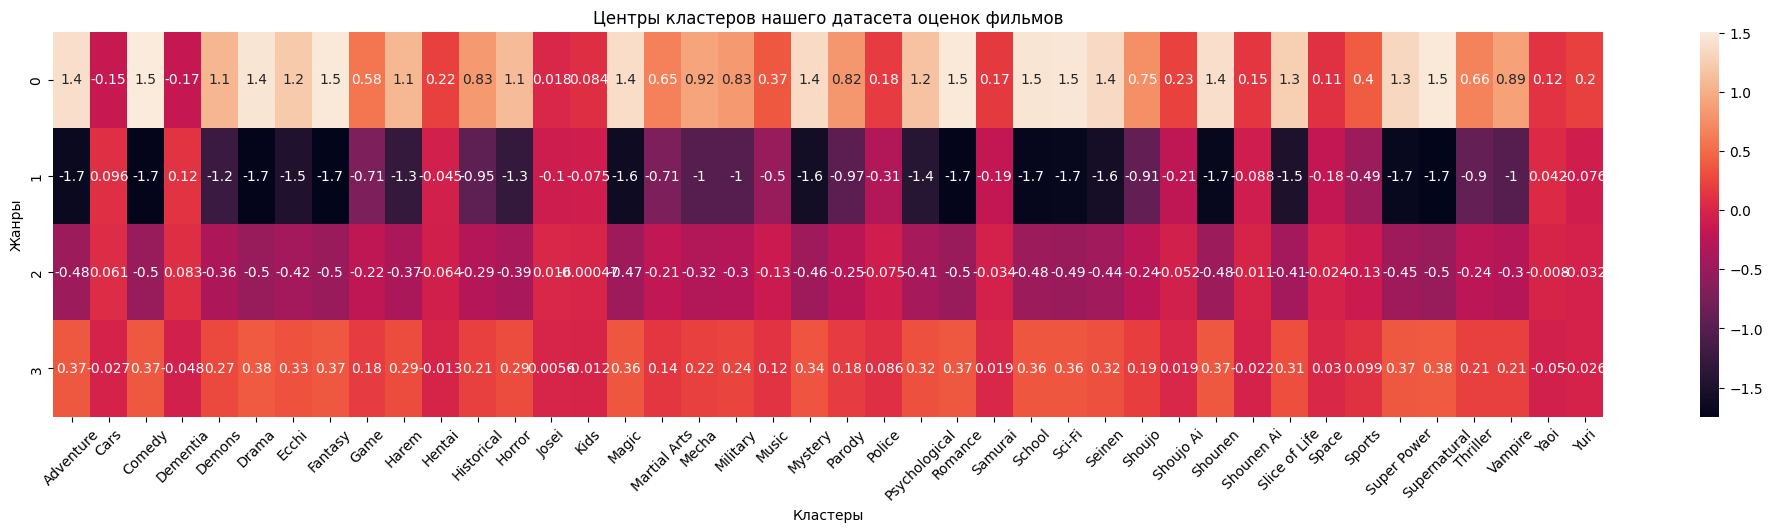

In [57]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(user_genre_ratings)
scaled_df = pd.DataFrame(scaled, columns=genre_columns, index=user_genre_ratings.index)

kmeans = KMeans(n_clusters=4, random_state=0)
scaled_df.fillna(0, inplace=True)
clusters = kmeans.fit_predict(scaled_df)
scaled_df['cluster'] = clusters

cluster_centers = kmeans.cluster_centers_

cluster_centers_df = pd.DataFrame(cluster_centers, columns=scaled_df.columns[:-1])

plt.figure(figsize=(25, 5))
plt.title('Центры кластеров нашего датасета оценок фильмов')
sns.heatmap(cluster_centers_df, annot=True)
plt.xlabel('Кластеры')
plt.ylabel('Жанры')
plt.xticks(rotation=45)
plt.show()

### 18. Порекомендуйте что-нибудь абстрактному пользователю.
Это можно сделать разными способами. Как это сделать подумайте сами.

Возможные варианты решения:
 * в каждом кластере отсортировать жанры по тому, насколько жанр важен.
 * взять каждый кластер -> получить все аниме, которые смотрят в этом кластере -> отсортировать по рейтину.



In [59]:
reccomendations = {}

for cluster in range(len(cluster_centers_df)):
    cluster_center = cluster_centers_df.iloc[cluster]
    sorted_genre_indices = cluster_center.argsort()
    sorted_genres = cluster_centers_df.columns[sorted_genre_indices]
    reccomendations[cluster] = sorted_genres

reccomendations

{0: Index(['Dementia', 'Cars', 'Josei', 'Kids', 'Space', 'Yaoi', 'Shounen Ai',
        'Samurai', 'Police', 'Yuri', 'Hentai', 'Shoujo Ai', 'Music', 'Sports',
        'Game', 'Martial Arts', 'Thriller', 'Shoujo', 'Parody', 'Historical',
        'Military', 'Vampire', 'Mecha', 'Demons', 'Harem', 'Horror',
        'Psychological', 'Ecchi', 'Slice of Life', 'Super Power', 'Seinen',
        'Mystery', 'Magic', 'Adventure', 'Shounen', 'Drama', 'School', 'Sci-Fi',
        'Fantasy', 'Supernatural', 'Romance', 'Comedy'],
       dtype='object'),
 1: Index(['Supernatural', 'Fantasy', 'Comedy', 'Romance', 'Drama', 'School',
        'Shounen', 'Sci-Fi', 'Super Power', 'Adventure', 'Magic', 'Mystery',
        'Seinen', 'Slice of Life', 'Ecchi', 'Psychological', 'Harem', 'Horror',
        'Demons', 'Mecha', 'Military', 'Vampire', 'Parody', 'Historical',
        'Shoujo', 'Thriller', 'Martial Arts', 'Game', 'Music', 'Sports',
        'Police', 'Shoujo Ai', 'Samurai', 'Space', 'Josei', 'Shounen Ai',
 